# Cortical Actin Quantification

## Imports

In [35]:
import numpy as np
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from itertools import product
import os
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
import glob
import os


## Extract Boundaries from Images

Videos avi files. Drift correction performed already using StackReg package on ImageJ. 

In [60]:
def extractData(fileName, save_qc=True, qc_folder="QC_output", cell_thresh=0, cort_thresh=30):
    
    CortActinSeries = []
    AllCellSeries = []
    ContoursSeries = []

    cap = cv2.VideoCapture(fileName)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

    # Create a unique QC folder for this video
    if save_qc:
        base_dir = os.path.dirname(fileName)
        video_name = os.path.splitext(os.path.basename(fileName))[0]
        qc_path = os.path.join(base_dir, qc_folder, video_name)
        os.makedirs(qc_path, exist_ok=True)

    frame_idx = 0
    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Preprocess
        grayImg = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        # Remove scale bar/timer

        kernel = np.ones((3, 3), np.uint8)
        blurImg = cv2.GaussianBlur(grayImg,(3,3),0)
        erodeImg = cv2.erode(blurImg, kernel, iterations=1)
        
        # Cortical actin (fixed threshold)
        _, binImg = cv2.threshold(erodeImg, cort_thresh, 255, cv2.THRESH_BINARY)
        CortActinSeries.append(binImg)
        
        # Entire cell (manual threshold)
        _, binImgAll = cv2.threshold(erodeImg, cell_thresh, 255, cv2.THRESH_BINARY)
        AllCellSeries.append(binImgAll)

        # Contours for cortical actin
        contours, _ = cv2.findContours(binImg, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
        ContoursSeries.append(contours)
        
        # QC panels
        total_display = cv2.cvtColor(erodeImg, cv2.COLOR_GRAY2BGR)
        cort_display = cv2.cvtColor(binImg, cv2.COLOR_GRAY2BGR)
        cv2.drawContours(cort_display, contours, -1, (0,255,0), 1)
        allcell_display = cv2.cvtColor(binImgAll, cv2.COLOR_GRAY2BGR)

        combined = np.concatenate((total_display, cort_display, allcell_display), axis=1)

        # Overlay frame index + thresholds
        cv2.putText(combined, f"Frame {frame_idx}", (10,20),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255,255,255), 1, cv2.LINE_AA)
        cv2.putText(combined, f"Cort Thresh={cort_thresh}", (10,45),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,0), 1, cv2.LINE_AA)
        cv2.putText(combined, f"Cell Thresh={cell_thresh}", (10,65),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0,255,255), 1, cv2.LINE_AA)

        # Save QC image
        if save_qc:
            out_path = os.path.join(qc_path, f"frame_{frame_idx:04d}.png")
            cv2.imwrite(out_path, combined)

        frame_idx += 1

    cap.release()
    cv2.destroyAllWindows()
    cv2.waitKey(1)
    
    return CortActinSeries, AllCellSeries, length, width, height


# -------- Run on all videos in a folder --------
def batch_process(video_dir, ext="avi"):
    video_files = glob.glob(os.path.join(video_dir, f"*.{ext}"))
    for vid in video_files:
        print(f"Processing {vid} ...")
        extractData(vid, save_qc=True, qc_folder="QC_output")



## Quantify Difference Across Frames

In [61]:
# Input: Arrays of binarized images for (1) cortical actin and (2) entire cell + length/width/height of images
# Ouput: Representative metrics: avDiff is average number of pixels changing between frames, avActin is average 
# of pixels classified as actin, and avCell is average number of pixels classified as cell

def quantifyChange(CortActinSeries, AllCellSeries, length, width, height):
    avDiff = []
    avActin = []
    avCell = []
    for k in range(length - 1):
        diffs = 0 
        totalCortActin = 0
        totalCell = 0
        # Cosnider images in pairs
        for i,j in product(range(height), range(width)):
            currentVal = CortActinSeries[k][i, j]
            nextVal = CortActinSeries[k + 1][i, j]
            if currentVal != nextVal:
                diffs += 1
            if currentVal == 255:
                totalCortActin += 1
            if AllCellSeries[k][i, j] == 255:
                totalCell += 1
        avDiff.append(diffs)
        avActin.append(totalCortActin)
        avCell.append(totalCell)
    return np.mean(avDiff), np.mean(avActin), np.mean(avCell)

## Visualize Actin Across all Frames

In [62]:
# Inputs: Array of binarized images for cortical actin and image name
# Output: Saves figure with cumulative actin at each location over time series at designated location
def makePlots(CortActinSeries, image):
    total = np.zeros(CortActinSeries[0].shape)
    for n in CortActinSeries:
        total += n
    plt.clf()
    plt.figure(figsize=(8, 8))
    plt.contourf(total, 100, cmap=plt.cm.nipy_spectral)
    plt.title(image[:-4])
    plt.axis('off')

    # Ensure folder exists
    output_dir = "Cropped_Fast/CorticalActinQuant_Figures"
    os.makedirs(output_dir, exist_ok=True)

    # Save the image
    plt.savefig(f"{output_dir}/Superimposed {image[:-4]}.png", dpi=300)



## Main Function

In [63]:
def mainFunction(path, images):
    avDiffAll = []
    avActinAll = []
    avCellAll = []
    for image in images:
        if '.avi' in image and 'Modified' not in image:
            print(image)
            CortActinSeries, AllCellSeries, length, width, height = extractData(path + '/' + image)
            avDiff, avActin, avCell = quantifyChange(CortActinSeries, AllCellSeries, length, width, height)
            makePlots(CortActinSeries, image)
            avDiffAll.append(avDiff)
            avActinAll.append(avActin)
            avCellAll.append(avCell)
    return avDiffAll, avActinAll, avCellAll

### Day 1 Fast

fast_d1_01.avi
fast_d1_02.avi
fast_d1_03.avi
fast_d1_04.avi
fast_d1_05.avi
fast_d1_06.avi
fast_d1_07.avi
fast_d1_08.avi
fast_d1_09.avi
fast_d1_10.avi


<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

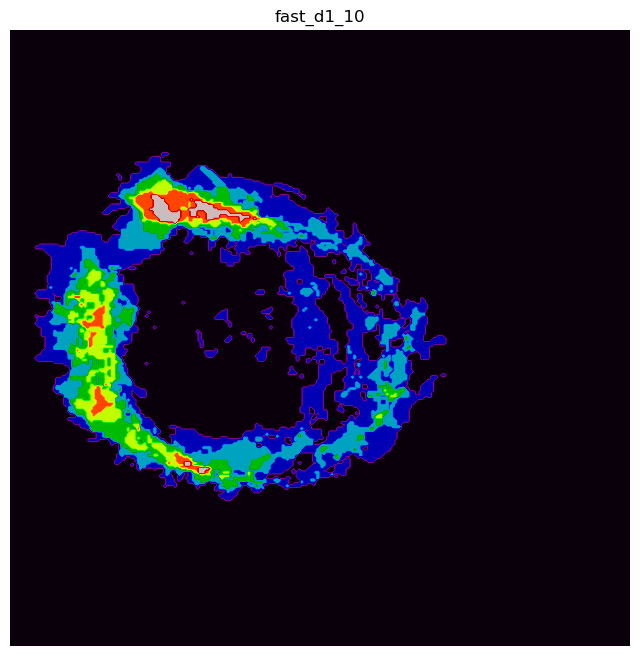

In [57]:
# Fast
path = ""
images = os.listdir(path)
images.sort()
avDiffAll_Fast, avActinAll_Fast, avCellAll_Fast = mainFunction(path, images)

### Day 1 SG

sg_d1_01.avi
sg_d1_010_5.08.avi
sg_d1_02.avi
sg_d1_03.avi
sg_d1_04.avi
sg_d1_05.avi
sg_d1_06.avi
sg_d1_07.avi
sg_d1_08_5.08.avi
sg_d1_09_5.08.avi


<Figure size 640x480 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

<Figure size 800x800 with 0 Axes>

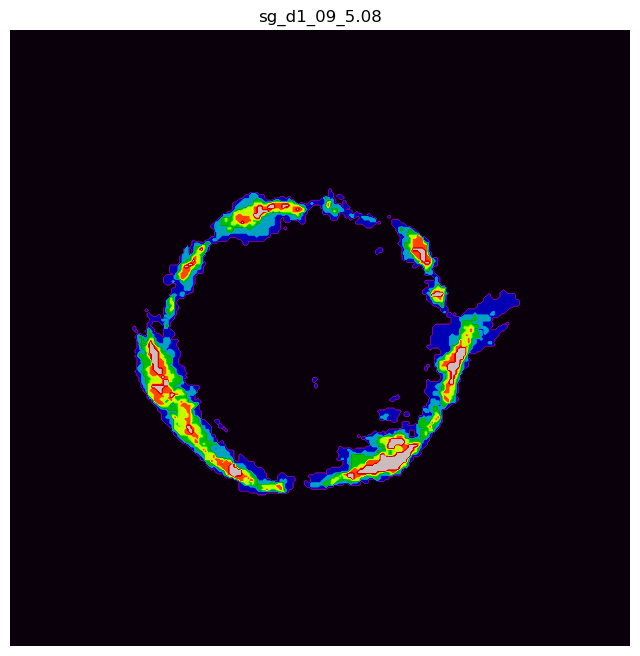

In [64]:
# SG
path = ""
images = os.listdir(path)
images.sort()
avDiffAll_SG, avActinAll_SG, avCellAll_SG = mainFunction(path, images)

### Dataframe for All

In [65]:
# Fast D1 
data = {'Fast Differences': avDiffAll_Fast, 'Total Actin': avActinAll_Fast, 'Total Cell': avCellAll_Fast}
df_Fast_D1 = pd.DataFrame(data)
# SG D1
data = {'SG Differences': avDiffAll_SG, 'Total Actin': avActinAll_SG, 'Total Cell': avCellAll_SG}
df_SG_D1 = pd.DataFrame(data)
# Combine All data

import os

# Make sure the folder exists
os.makedirs("Cortical Actin/Final Data", exist_ok=True)

# Save CSV
allData = pd.concat([df_Fast_D1, df_SG_D1], axis=1)
allData.to_csv("Cortical Actin/Final Data/cropped_allData.csv")


In [26]:
allData

,Fast Differences,Total Actin,Total Cell,SG Differences,Total Actin,Total Cell
0,3080.2,2328.0,19678.4,1685.6,1025.2,12365.4
1,2556.8,1545.8,15757.4,1845.6,1754.4,13991.8
2,779.4,452.0,7948.2,1475.2,1257.4,9156.6
3,2692.2,2359.0,5653.8,1259.4,727.6,12409.0
4,1853.6,1094.2,22834.4,1892.0,1356.0,14321.6
5,2378.0,1597.6,24818.0,758.0,473.4,10545.2
6,2100.2,1820.8,7155.4,1840.6,1346.8,8600.2
7,2711.4,1952.2,21189.0,3479.2,3373.8,28161.0
8,3659.6,2584.8,8562.0,2091.0,1366.6,9240.2
9,5296.8,4831.2,10166.6,2111.8,2474.0,3628.6
